In [13]:
import modele as mod
import sections as s
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import plotly.express as px
import xarray as xr


## Caractéristiques de la route

In [14]:
N = 100                        #Taille de la route (en mailles)   
U_init = np.zeros(N)           #Discrétisation de la route
#U_init[0:30] = 100
h = 0.1                         #Taille de chaque maille (en km)
I = 1                          #Nombre de lignes
nom = "Section solo test"

## Caractéristiques de la simulation

In [15]:
p_c = 100.                     #Densité critique (en vh/km)
p_max = 150.                   #Densité max (en vh/km)
V_0 = 50.                      #Vitesse souhaitée (en km/h)                         
flux_entrant = 800            #Flux de véhicules entrant (en vh/h)
fl_fix = flux_entrant
#flux_t_entrant = 0            #Flux de temps d'attente
#T = 1.4/3600                   #Temps de réaction
dt =  0.99*(h/V_0)             #CFL

In [16]:
def plus(route):  
    route.flux_entrant+=500


def moins(route):
    if route.flux_entrant - 500>=0:
        route.flux_entrant-=500

## Définitions des objets et def

In [17]:
#Définition de la route
route = s.section(p_max = p_max, V_0 = V_0, I = I, U = U_init, flux_entrant=flux_entrant, p_c = p_c, nom = nom, sortie=True)

init
I = 1
p_max = 150.0
T = 6.666666666666667e-05
2.0
La route Section solo test a p_c = 75.0


In [18]:
#Définition du modèle
model = mod.model([route], intersections= None, carrefours= None, dt = dt, h = h)

In [19]:
#Variation du flux d'entrée
def variation(route, fl_fix):
    sigma = np.random.normal(0,0.1)
    if (int(route.flux_entrant + sigma*fl_fix)>0 and int(route.flux_entrant + sigma*fl_fix)<1600):
        route.flux_entrant = route.flux_entrant + sigma*fl_fix


    

# La suite à ne pas executer si on veut lancer MONTE CARLO !!!!

## Visualisation

AttributeError: 'FuncAnimation' object has no attribute 'writers'

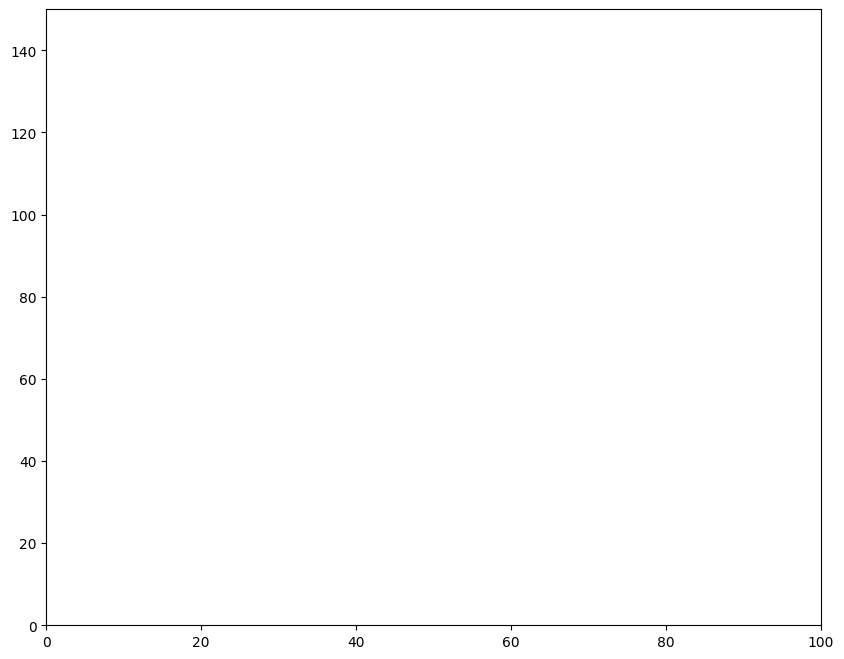

In [22]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(xlim=(0, N), ylim=(0, 150))
line, = plt.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    model.resoudre()
    variation(route)
    x = np.linspace(0, N-1, N)
    y = route.U
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, init_func=init, frames=500, interval=50, blit=True)

anim.save('densite_evolution.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

## Monte Carlo

In [ ]:
def init_route():

    N = 100                        #Taille de la route (en mailles)   
    U_init = np.zeros(N)           #Discrétisation de la route
    #U_init[0:30] = 100
    h = 0.1                         #Taille de chaque maille (en km)
    I = 1                          #Nombre de lignes
    nom = "Section solo test"
    p_c = 100.                     #Densité critique (en vh/km)
    p_max = 150.                   #Densité max (en vh/km)
    V_0 = 50.                      #Vitesse souhaitée (en km/h)                         
    flux_entrant = 800            #Flux de véhicules entrant (en vh/h)
    fl_fix = flux_entrant
    #flux_t_entrant = 0            #Flux de temps d'attente
    #T = 1.4/3600                   #Temps de réaction
    dt =  0.99*(h/V_0)             #CFL

    route = s.section(p_max = p_max, V_0 = V_0, I = I, U = U_init, flux_entrant=flux_entrant, p_c = p_c, nom = nom, sortie=True)
    model = mod.model([route], intersections= None, carrefours= None, dt = dt, h = h)

    return route, model

In [ ]:
def simulation(T):
    # T correspond au nombre de pas de temps qu'on veut pour notre simulation
    pho_global = np.zeros((T-100,N))
    route, model = init_route()

    for i in range(T):
        model.resoudre()
        variation(route, fl_fix)
        if i>=100:
            pho_global[i-100] = route.U

    return np.asarray(pho_global)

In [ ]:
def MC_sim(M, simulator, T, N):
    # M correspond au nombre d'iter pour MC
    # simulator correspond au modèle à simuler
    stockage = []
    for m in range(M):
        sim = simulator(T)
        stockage.append(sim)
    return stockage

In [ ]:
mc_values = MC_sim(100, simulation, 200, N)

In [ ]:
np.shape(mc_values)

In [ ]:
from matplotlib.widgets import Slider, Button
from ipywidgets import *

def density_dist(mc_v, t, x):
    return mc_v[:][t][x]

init_t = 70
init_x = 81




%matplotlib inline
fig, ax = plt.subplots()
line, = ax.plot(density_dist(mc_values, init_t, init_x), lw=2)
ax.set_xlabel('Densité (vh/maille')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Position [Maille]',
    valmin=0,
    valmax=100,
    valinit=init_x,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Time [dt]",
    valmin=0,
    valmax=100,
    valinit=init_t,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(density_dist(amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
# resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
# button = Button(resetax, 'Reset', hovercolor='0.975')


# def reset(event):
#     freq_slider.reset()
#     amp_slider.reset()
#button.on_clicked(reset)

plt.show()

In [ ]:
from matplotlib.widgets import Slider, Button
from ipywidgets import *

def density_dist(mc_v, t, x):
    return mc_v[:][t][x]

init_t = 70
init_x = 81


%matplotlib inline
fig, ax = plt.subplots()
line, = ax.plot(density_dist(mc_values, init_t, init_x), lw=2)
ax.set_xlabel('Densité (vh/maille')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Position [Maille]',
    valmin=0,
    valmax=100,
    valinit=init_x,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Time [dt]",
    valmin=0,
    valmax=100,
    valinit=init_t,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(density_dist(mc_values,amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
#interact(update)
freq_slider.on_changed(update)
amp_slider.on_changed(update)


plt.show()

In [ ]:

np.asarray(mc_values).tofile('mc.csv', sep =",")

In [ ]:
%matplotlib inline

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update)

